In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

from dotenv import load_dotenv
import os

from langchain_google_vertexai import ChatVertexAI

from langchain_community.tools.tavily_search import TavilySearchResults

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage


from typing import Annotated #Annotated allows adding extra information, in this case, the reducer function, aside from just specifying a data type
from langgraph.graph.message import add_messages

from langgraph.graph import MessagesState

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

from langgraph.checkpoint.memory import MemorySaver


In [2]:
# Load environment variables from .env file
load_dotenv()

# Access the environment variable
tavily_api_key = os.getenv("TAVILY_API_KEY")

if not tavily_api_key:
    raise ValueError("TAVILY_API_KEY is not set. Please check your .env file.")

print("TAVILY_API_KEY loaded successfully!")

TAVILY_API_KEY loaded successfully!


In [3]:
gundam_messages = [AIMessage(content=f"So you said you were researching life-sized Gundams?", name="Model")]
gundam_messages.append(HumanMessage(content=f"Yes, that's right.",name="Kokko"))
gundam_messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
gundam_messages.append(HumanMessage(content=f"I want to learn about the best place to see life-sized Gundams in Japan", name="Kokko"))

for m in gundam_messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching life-sized Gundams?
================================ Human Message =================================
Name: Kokko

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Kokko

I want to learn about the best place to see life-sized Gundams in Japan


In [4]:
# Create a message
msg = HumanMessage(content="Hello world", name="Kokko")

# Message list
basic_messages = [msg]

In [5]:
tavily_search = TavilySearchResults(max_results=3)

In [6]:
llm = ChatVertexAI(model="gemini-1.5-flash-002", temperature=0)

In [7]:
llm_with_tavily = llm.bind_tools([tavily_search])

In [8]:
class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [9]:
#define the tool calling node
def llm_with_tavily_tool_call_node(state: MessagesState):
    return {"messages": [llm_with_tavily.invoke(state["messages"])]}

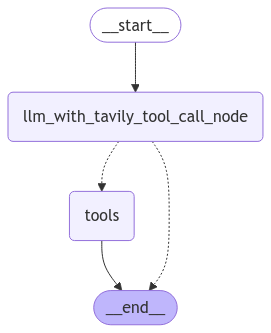

In [10]:
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("llm_with_tavily_tool_call_node", llm_with_tavily_tool_call_node)
builder.add_node("tools", ToolNode([tavily_search]))
builder.add_edge(START, "llm_with_tavily_tool_call_node")
builder.add_conditional_edges(
    "llm_with_tavily_tool_call_node",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
type(basic_messages)

list

In [12]:
basic_messages = graph.invoke({"messages": basic_messages}) #this type change from list to langgraph.pregel.io.AddableValuesDict is best practice in Langgraph


In [13]:
type(basic_messages)

langgraph.pregel.io.AddableValuesDict

In [14]:
gundam_messages = graph.invoke({"messages": gundam_messages}) 

In [15]:
gundam_messages

{'messages': [AIMessage(content='So you said you were researching life-sized Gundams?', additional_kwargs={}, response_metadata={}, name='Model', id='4fc8e072-322c-452c-8e2f-2aafe55b85e7'),
  HumanMessage(content="Yes, that's right.", additional_kwargs={}, response_metadata={}, name='Kokko', id='2a3492ec-068d-4aa7-9aa3-4fccbf7358b9'),
  AIMessage(content='Great, what would you like to learn about.', additional_kwargs={}, response_metadata={}, name='Model', id='a6d886f2-b0a8-47d2-bede-8fa916aef363'),
  HumanMessage(content='I want to learn about the best place to see life-sized Gundams in Japan', additional_kwargs={}, response_metadata={}, name='Kokko', id='23ad5062-7f14-462a-90ae-7bc6a34ccf6d'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "best place to see life-sized Gundams in Japan"}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 93, 'candidates_

In [16]:
for m in gundam_messages['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching life-sized Gundams?
================================ Human Message =================================
Name: Kokko

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Kokko

I want to learn about the best place to see life-sized Gundams in Japan
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (2ff8d411-e944-45e8-a827-48832d48cfd0)
 Call ID: 2ff8d411-e944-45e8-a827-48832d48cfd0
  Args:
    query: best place to see life-sized Gundams in Japan
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.kkday.com/en/blog/60189/asi

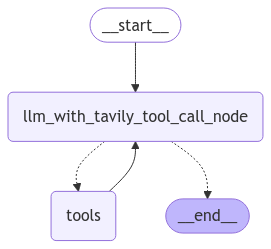

In [17]:
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("llm_with_tavily_tool_call_node", llm_with_tavily_tool_call_node)
builder.add_node("tools", ToolNode([tavily_search]))
builder.add_edge(START, "llm_with_tavily_tool_call_node")
builder.add_conditional_edges(
    "llm_with_tavily_tool_call_node",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "llm_with_tavily_tool_call_node")
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
gundam_messages = graph.invoke({"messages": gundam_messages["messages"]}) 

In [19]:
for m in gundam_messages['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching life-sized Gundams?
================================ Human Message =================================
Name: Kokko

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Kokko

I want to learn about the best place to see life-sized Gundams in Japan
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (2ff8d411-e944-45e8-a827-48832d48cfd0)
 Call ID: 2ff8d411-e944-45e8-a827-48832d48cfd0
  Args:
    query: best place to see life-sized Gundams in Japan
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.kkday.com/en/blog/60189/asi

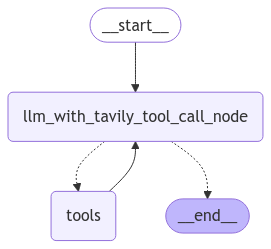

In [20]:
# Build graph
builder = StateGraph(MessagesState)
memory = MemorySaver()
builder.add_node("llm_with_tavily_tool_call_node", llm_with_tavily_tool_call_node)
builder.add_node("tools", ToolNode([tavily_search]))
builder.add_edge(START, "llm_with_tavily_tool_call_node")
builder.add_conditional_edges(
    "llm_with_tavily_tool_call_node",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "llm_with_tavily_tool_call_node")
react_graph_memory = builder.compile(checkpointer=memory)
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
gundam_messages = [AIMessage(content=f"So you said you were researching life-sized Gundams?", name="Model")]
gundam_messages.append(HumanMessage(content=f"Yes, that's right.",name="Kokko"))
gundam_messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
gundam_messages.append(HumanMessage(content=f"I want to learn about the best place to see life-sized Gundams in Japan", name="Kokko"))

for m in gundam_messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching life-sized Gundams?
================================ Human Message =================================
Name: Kokko

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Kokko

I want to learn about the best place to see life-sized Gundams in Japan


In [22]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Run
gundam_messages = react_graph_memory.invoke({"messages": gundam_messages}, config)

for m in gundam_messages["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching life-sized Gundams?
================================ Human Message =================================
Name: Kokko

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Kokko

I want to learn about the best place to see life-sized Gundams in Japan
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1cfaae92-ea1a-4ccc-b01f-4402b14dfd1b)
 Call ID: 1cfaae92-ea1a-4ccc-b01f-4402b14dfd1b
  Args:
    query: best place to see life-sized Gundams in Japan
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.kkday.com/en/blog/60189/asi

In [23]:
new_gundam_messages = [HumanMessage(content="Which Gundam series are these Gundams a part of?")]

# Run
new_gundam_messages = react_graph_memory.invoke({"messages": new_gundam_messages}, config)

for m in new_gundam_messages["messages"]:
    m.pretty_print()


================================== Ai Message ==================================
Name: Model

So you said you were researching life-sized Gundams?
================================ Human Message =================================
Name: Kokko

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Kokko

I want to learn about the best place to see life-sized Gundams in Japan
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1cfaae92-ea1a-4ccc-b01f-4402b14dfd1b)
 Call ID: 1cfaae92-ea1a-4ccc-b01f-4402b14dfd1b
  Args:
    query: best place to see life-sized Gundams in Japan
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.kkday.com/en/blog/60189/asi